# 9. We don't need PCA

In this notebook, we will see that we don't need to create embeddings using PCA and the matrix of score is a sufficient embeddings. We will then compare this new methods to the previous ones.

In [1]:
import embedded_voting as ev
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
np.random.seed(42)

In the next cells, I just copy the setup from the previous notebook

In [2]:
list_rules = [ev.SVDNash(),
              ev.SumScores(), ev.ProductScores()]

list_names = ["SVDNash",
              "SumScores", "ProductScores",
              "FakeSVDNash", "FakeSVDNash+exp", "MLERule", "MLERule (1000)"]

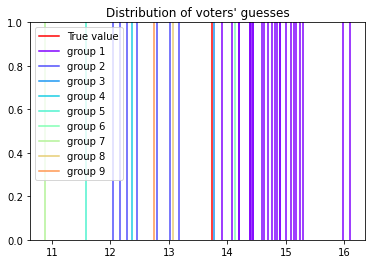

In [3]:
groups_sizes = [25, 7, 1, 1, 1,1, 1, 1, 1]
#groups_sizes = [25, 4, 1, 1, 1]
features = [[1, 0, 0, 0, 0 , 0, 1], #25
            [0, 1, 0, 0, 0 , 0, 1], #7
            [1, 0, 1, 0, 0 , 0, 1], 
            [0, 1, 1, 0, 0 , 0, 1], 
            [0, 0, 1, 0, 0 , 0, 1],
            [0, 0, 0, 1, 0 , 0, 1],
            [0, 0, 0, 0, 1 , 0, 1],
            [0, 0, 0, 0, 0 , 1, 1],
            [0, 0, 0, 0, 0 , 0, 1],
           ]

generator = ev.GroupedMixGenerator(groups_sizes, features)
generator.set_group_noise(8)
generator.set_independent_noise(0.5)
generator.plot_scores()

In [4]:
n_voters = int(np.sum(groups_sizes))
n_candidates = 20

Here is the main function, a little bit modified

In [5]:
def transform_score(s):
    return np.exp((s - np.mean(s))/np.std(s))

## Evolution with training size

In [6]:

max_training = 100

add_training = 10

def online_learning():
    results = []
    tab_training = []
    total_training = np.zeros((n_voters, 0))
    n_training = 0

    while n_training <= max_training:
        truth, scores = generator.sample_scores(n_candidates)

        # We get the real welfare of each candidate using a SumScoresProfile 
        true_profile = ev.Profile(n_candidates, 0)
        true_profile.add_voter([], truth)
        target = ev.SumScores(true_profile)
        welfare = target.welfare_

        # We create the profile of voters-algorithms
        profile = ev.AutoProfile(n_candidates, 0)
        profile.add_voters_auto(scores, total_training)

        # We get the preformance of every rule
        n_training = total_training.shape[1]
        results_i = []
        for rule in list_rules:
            w = rule(profile).winner_
            results_i.append(welfare[w])

        
        # We get the performance of FakeSVD
        profile = ev.AutoProfile(n_candidates, 0)
        profile.add_voters_fake(scores, total_training)
        w = ev.FastNash(profile, lambda x: np.sqrt(np.maximum(0,x/np.linalg.norm(x)))).winner_

        results_i.append(welfare[w])
        
        w = ev.NoPCA(profile, lambda x: np.sqrt(np.maximum(0,transform_score(x)))).winner_
        results_i.append(welfare[w])
        
        results.append(results_i)
        
        
        # We get the performance of MLE
        profile = ev.AutoProfile(n_candidates, n_voters)
        profile.add_voters_cov(scores, total_training)
        w = ev.MLERule(profile).winner_
        results_i.append(welfare[w])

        tab_training.append(n_training)

        total_training = np.concatenate([total_training, generator.sample_scores(add_training)[1]], axis=1)

    results = np.array(results).T
    return results

In [7]:

def online_learning_nv():
    results = []
    tab_training = []
    total_training = np.zeros((n_voters, 0))
    n_training = 0

    while n_training <= max_training:
        results_i = []
        truth, scores = generator.sample_scores(n_candidates)
        n_training = total_training.shape[1]

        # We get the performance of FakeSVD
        profile = ev.AutoProfile(n_candidates, 0)
        profile.add_voters_fake(scores, total_training)
        w = ev.FastNash(profile, lambda x: np.sqrt(np.maximum(0,x/np.linalg.norm(x)))).n_v

        results_i.append(w)
        
        w = ev.NoPCA(profile, lambda x: np.sqrt(np.maximum(0,transform_score(x)))).n_v
        results_i.append(w)
        
        results.append(results_i)
        

        tab_training.append(n_training)

        total_training = np.concatenate([total_training, generator.sample_scores(add_training)[1]], axis=1)

    results = np.array(results).T
    return results

In [8]:
n_steps = (max_training+1)//add_training + 1
results = np.zeros((len(list_rules)+3, n_steps))
n_trys = 100
for i in tqdm(range(n_trys)):
    results += online_learning()

results = results/n_trys

  0%|          | 0/100 [00:00<?, ?it/s]


AttributeError: module 'embedded_voting' has no attribute 'NoPCA'

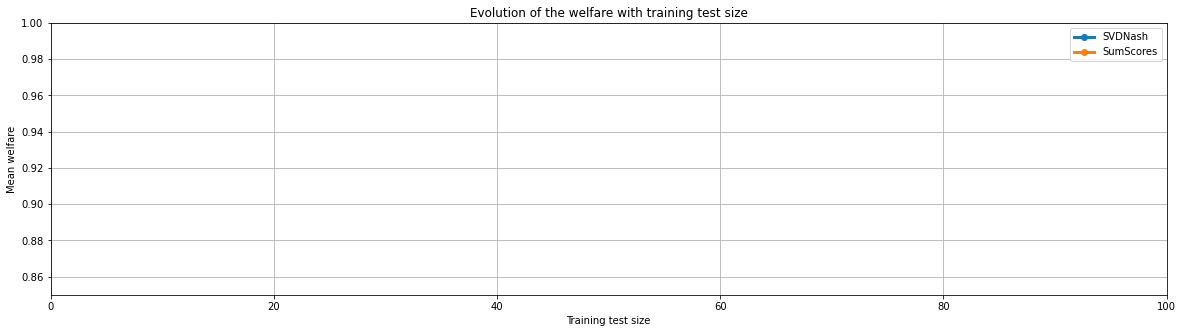

In [67]:
fig = plt.figure(figsize=(20, 5))
for i, r in enumerate(results):
    plt.plot(np.linspace(0,max_training,n_steps), r, 'o-', label=list_names[i]
             , linewidth=3)
    
plt.ylim(0.85, 1)
plt.xlim(0,max_training)
plt.xlabel("Training test size")
plt.ylabel("Mean welfare")
plt.title("Evolution of the welfare with training test size")
plt.legend()
plt.grid(0.3)
plt.show()

In [9]:
n_steps = (max_training+1)//add_training + 2
results = np.zeros((2, n_steps))
n_trys = 100
for i in tqdm(range(n_trys)):
    results += online_learning_nv()

results = results/n_trys

  0%|          | 0/100 [00:00<?, ?it/s]


AttributeError: 'FastNash' object has no attribute 'n_v'

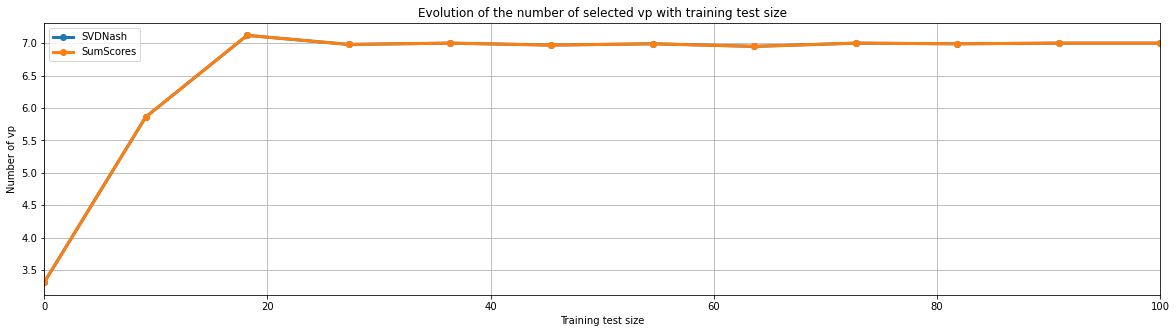

In [59]:
fig = plt.figure(figsize=(20, 5))
for i, r in enumerate(results):
    plt.plot(np.linspace(0,max_training,n_steps), r, 'o-', label=list_names[i]
             , linewidth=3)
    
plt.xlim(0,max_training)
plt.xlabel("Training test size")
plt.ylabel("Number of vp")
plt.title("Evolution of the number of selected vp with training test size")
plt.legend()
plt.grid(0.3)
plt.show()

## Evolution with noise

In [21]:
def noise_evolution(noise_kind="group", min_noise=0, max_noise=20, training_size=100, training_size_mle=[]):
    results = []
    
    noises = np.linspace(min_noise, max_noise, 20)
    for noise in noises:
        if noise_kind == "group":
            generator.set_group_noise(noise)
        elif noise_kind == "independent":
            generator.set_independent_noise(noise)
        else:
            raise ValueError("bad parameter")
            
        truth, scores = generator.sample_scores(20)
        _, training = generator.sample_scores(training_size)

        # We get the real welfare of each candidate using a SumScoresProfile 
        true_profile = ev.Profile(n_candidates, 0)
        true_profile.add_voter([], truth)
        target = ev.SumScores(true_profile)
        welfare = target.welfare_

        # We create the profile of voters-algorithms
        profile = ev.AutoProfile(n_candidates, 0)
        profile.add_voters_auto(scores, training)

        # We get the preformance of every rule
        results_i = []
        for rule in list_rules:
            w = rule(profile).winner_
            results_i.append(welfare[w])
            
        # We get the performance of FakeSVD
        profile = ev.AutoProfile(n_candidates, 0)
        profile.add_voters_fake(scores, training)
        w = ev.NoPCA(profile, lambda x: np.sqrt(np.maximum(0,x/np.linalg.norm(x)))).winner_

        results_i.append(welfare[w])
        
        w = ev.NoPCA(profile, lambda x: np.sqrt(np.maximum(0,transform_score(x)))).winner_
        results_i.append(welfare[w])
        
        

        # We get the performance of MLE
        profile = ev.AutoProfile(n_candidates, n_voters)
        profile.add_voters_cov(scores, training)
        w = ev.MLERule(profile).winner_
        results_i.append(welfare[w])
        
        for size in training_size_mle:
            _, training = generator.sample_scores(size)
            # We get the performance of MLE
            profile.add_voters_cov(scores, training)
            w = ev.MLERule(profile).winner_
            results_i.append(welfare[w])

        results.append(results_i)

    results = np.array(results).T
    return results

In [23]:
min_noise = 0
max_noise = 20
results = np.zeros((len(list_rules)+4, 20))

generator.set_independent_noise(0.5)

n_trys = 200
for i in tqdm(range(n_trys)):
    results += noise_evolution("group", min_noise, max_noise, training_size_mle=[1000])

results = results/n_trys

100%|██████████| 200/200 [18:03<00:00,  5.42s/it]


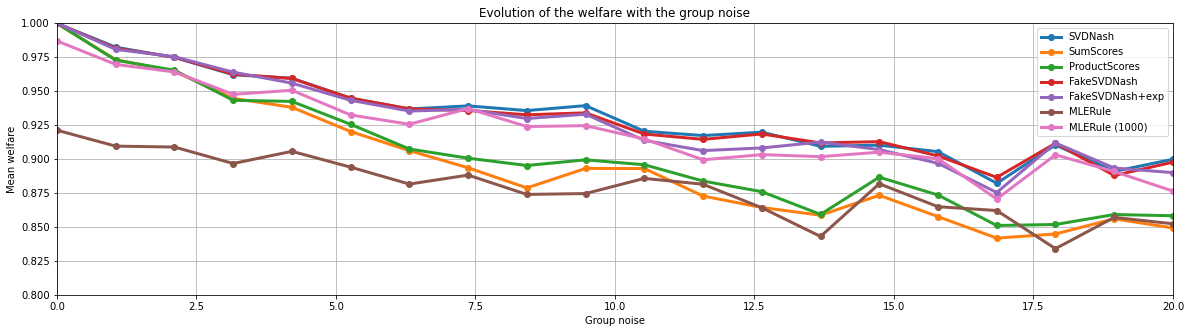

In [24]:
tab_training = np.linspace(min_noise, max_noise, 20)

fig = plt.figure(figsize=(20, 5))

for i, r in enumerate(results):
    plt.plot(tab_training, r, 'o-', label=list_names[i], linewidth=3)
    
plt.ylim(0.8, 1)
plt.xlim(0,max_noise)
plt.legend()
plt.xlabel("Group noise")
plt.ylabel("Mean welfare")
plt.title("Evolution of the welfare with the group noise")
plt.grid(0.3)
plt.legend()
plt.show()

In [25]:
min_noise = 0
max_noise = 10
results = np.zeros((len(list_rules)+4, 20))

generator.set_group_noise(10)

n_trys = 200
for i in tqdm(range(n_trys)):
    results += noise_evolution("independent", min_noise, max_noise, training_size_mle=[1000])

results = results/n_trys

100%|██████████| 200/200 [17:54<00:00,  5.37s/it]


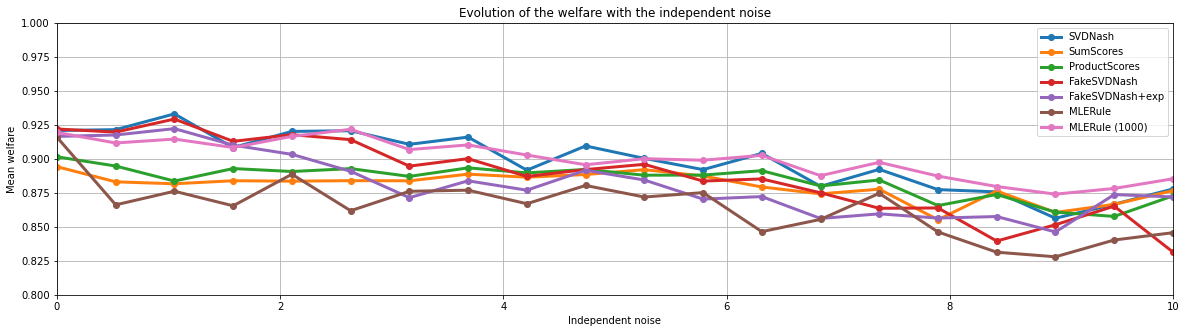

In [26]:
tab_training = np.linspace(min_noise, max_noise, 20)

fig = plt.figure(figsize=(20, 5))

for i, r in enumerate(results):
    plt.plot(tab_training, r, 'o-', label=list_names[i], linewidth=3)
    
plt.ylim(0.8, 1)
plt.xlim(0,max_noise)
plt.legend()
plt.xlabel("Independent noise")
plt.ylabel("Mean welfare")
plt.title("Evolution of the welfare with the independent noise")
plt.grid(0.3)
plt.legend()
plt.show()